## Using ALOS PALSAR and Forest/Non-Forest Annual Mosaics with the Planetary Computer STAC API

ALOS PALSAR Annual Mosaic consist of radar backscatter in the HH and HV with additional bands for ancillary information about incidince angle, masking, and date of acquisition (per pixel).

For this example we'll find a 1x1 degree data tile with a diversity of values, and plot the HH, HV and matching Forest Classification.

In [1]:
import numpy as np
import planetary_computer
import rioxarray
import stackstac
from pystac_client import Client

### Polarization Returns

In [2]:
aoi = [9.4, 0, 9.5, 1]
client = Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/",
)
search = client.search(
    collections=["alos-palsar-mosaic"],
    bbox=aoi,
)
items = search.get_all_items()
print(f"Returned {len(items)} items")

Returned 6 items


In [3]:
item = items[0]
print(item.assets)

{'HH': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_sl_HH_F02DAR.tif>, 'HV': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_sl_HV_F02DAR.tif>, 'date': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_date_F02DAR.tif>, 'mask': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_mask_F02DAR.tif>, 'linci': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_linci_F02DAR.tif>, 'tilejson': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/tilejson.json?collection=alos-palsar-mosaic&item=N01E009_17_MOS&assets=HH&>, 'rendered_preview': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/preview.png?collection=alos-palsar-mosaic&item=N01E009_17_MOS&assets=HH&>}


In [4]:
import geopandas

geopandas.GeoDataFrame.from_features(items.to_dict()["features"]).set_crs(
    "epsg:4326"
).explore()

In [5]:
signed_item = planetary_computer.sign(item)

data = stackstac.stack(
    signed_item,
    assets=["HH", "HV"],  # Both Polarizations
    dtype="uint16",
    fill_value=0,
).squeeze()
data

# TODO consider applying conversion to dB from DN
# 10 * np.log10(data) - 83 # 83 can come out of the cf property in STAC

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-2aaea32b787c49b9f6704b37047df663' (band: 2,
                                                                y: 4500, x: 4500)>
dask.array<getitem, shape=(2, 4500, 4500), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
    time                 datetime64[ns] 2017-01-01
    id                   <U14 'N01E009_17_MOS'
  * band                 (band) <U2 'HH' 'HV'
  * x                    (x) float64 9.0 9.0 9.0 9.001 ... 9.999 9.999 10.0 10.0
  * y                    (y) float64 1.0 0.9998 0.9996 ... 0.0004444 0.0002222
    sar:product_type     <U3 'GTC'
    ...                   ...
    title                (band) <U2 'HH' 'HV'
    instruments          <U8 'PALSAR-2'
    start_datetime       <U20 '2017-01-01T00:00:00Z'
    gsd                  int64 25
    raster:bands         object {'nodata': 0, 'data_type': 'uint16'}
    epsg                 int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(9.0, 0.0, 10.0, 1.0), resoluti...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 9.00|\n| 0.00,-0.00, 1.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00022222222222222223

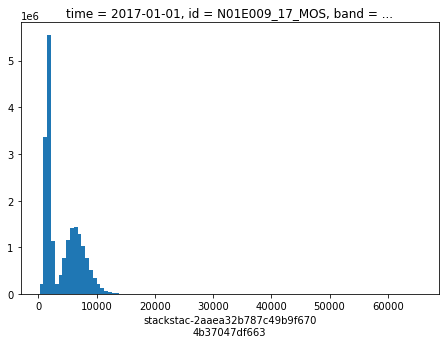

In [6]:
data.sel(band="HH").plot.hist(bins=100, size=5);

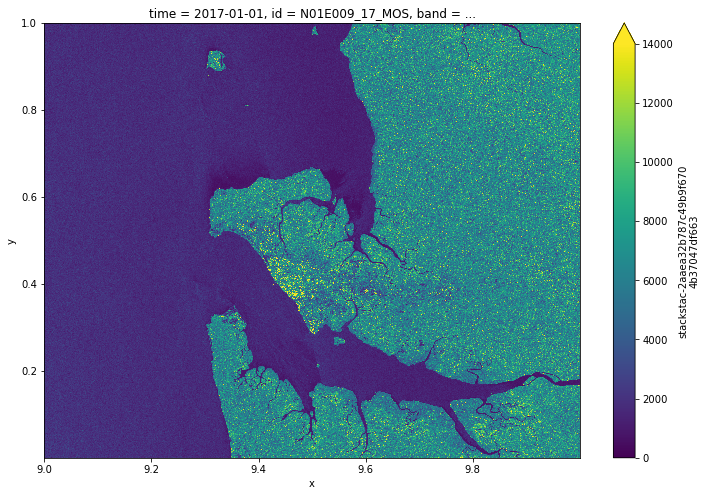

In [7]:
data.sel(band="HH").plot(vmin=0, vmax=14000, size=8);

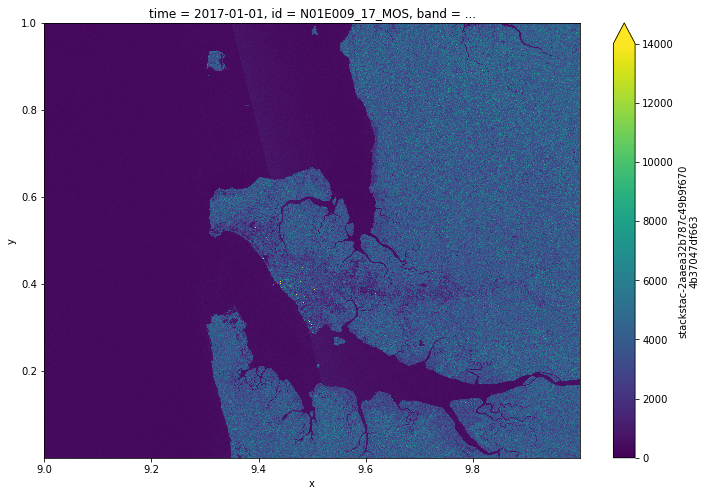

In [8]:
data.sel(band="HV").plot(vmin=0, vmax=14000, size=8);

### Forest Classification

ALOS Forest/Non-Forest Classification is derived from the ALOS PALSAR Annual Mosaic, and classifies the pixels to detect forest cover.

In [9]:
client = Client.open("https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/")
search = client.search(
    collections=["alos-fnf-mosaic"],
)
fnf_items = list(search.get_items())
print(f"Returned {len(fnf_items)} items")

Returned 500 items


In [10]:
fnf_item = fnf_items[13]  # TODO: make sure sample is 2015 or 2016
fnf_item.assets

{'C': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_fnf_mosaic/N01E009_17_C_F02DAR.tif>,
 'tilejson': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/tilejson.json?collection=alos-fnf-mosaic&item=N01E009_17_FNF&assets=C&>,
 'rendered_preview': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/preview.png?collection=alos-fnf-mosaic&item=N01E009_17_FNF&assets=C&>}

In [11]:
fnf_signed_asset = planetary_computer.sign(fnf_item.assets["C"])
fnf_tile = rioxarray.open_rasterio(fnf_signed_asset.href)
fnf_tile

<xarray.DataArray (band: 1, y: 4500, x: 4500)>
[20250000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 9.0 9.0 9.001 9.001 9.001 ... 9.999 9.999 10.0 10.0
  * y            (y) float64 0.9999 0.9997 0.9994 ... 0.0003333 0.0001111
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

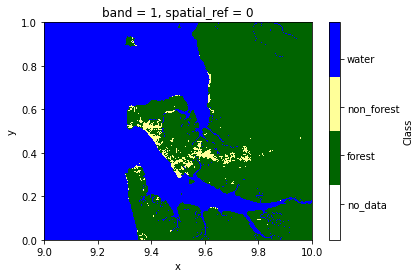

In [12]:
from matplotlib.colors import ListedColormap

# Get the color palette from the source file
colors = fnf_tile.rio._manager.acquire().colormap(1)

classes = fnf_item.get_collection().extra_fields["item_assets"]["C"]["raster:bands"][0][
    "classification:classes"
]
class_names = {x["name"]: x["value"] for x in classes}
values_to_classes = {v: k for k, v in class_names.items()}

# Convert for use with plotting
colormap = [
    np.array(colors[i]) / 255 for i in range(len(class_names.values()))
]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

# Plot the classification map
p = fnf_tile.plot(cmap=cmap, vmin=0, vmax=3)
ticks = np.linspace(0.5, 2.5, 4)
labels = [values_to_classes.get(i, "") for i in range(cmap.N)]
p.colorbar.set_ticks(ticks, labels=labels)
p.colorbar.set_label("Class")